In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
import itertools
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timedelta, timezone

def get_BJ_time():
    # 拿到UTC时间，并强制设置时区为UTC+0:00
    utc_dt = datetime.utcnow().replace(tzinfo=timezone.utc)
    # astimezone()将转换时区为北京时间
    bj_dt = utc_dt.astimezone(timezone(timedelta(hours=8)))
    current_time = bj_dt.strftime('%m%d_%H-%M-%S')

    return current_time

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("efficientB4.pdf")
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

current_time = get_BJ_time()
print(current_time)

df_2015 = pd.read_csv('aptos-data-split/df_2015_cv.csv')
df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')

df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

test_df = pd.read_csv('2019data/sample_submission.csv')

bs = 32 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# df_2015 = pd.read_csv('aptos-data-split/df_2015_cv.csv')
# df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')

# df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
# df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

# test_df = pd.read_csv('2019data/sample_submission.csv')

data = (ImageList.from_df(df=df,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)
df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')
df_2019['is_valid'] = [False]*2929 + [True]*733
data_2019 = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
learn = Learner(data_2019, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')
# learn.data.add_test(ImageList.from_df(test_df,
#                                       '2019data',
#                                       folder='test_images_ben_preprocessing_sigmaX10',
#                                       suffix='.png'))


0401_00-53-00
Loaded pretrained weights for efficientnet-b4


In [3]:
data_2019

ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,1.0,0.0,4.0,2.0
Path: .;

Test: None

In [4]:
model_save_name = "EfficientNetWithoutPreprocessing"
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20, 1.00E-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,1.096105,1.352038,0.511801,01:59
1,0.560003,0.448401,0.835998,02:01
2,0.433288,0.460588,0.845265,02:03
3,0.403201,0.353279,0.880387,01:59
4,0.362962,0.553256,0.836253,02:01
5,0.349251,0.691164,0.842743,02:01
6,0.342733,0.462427,0.862009,02:00
7,0.311910,0.298106,0.903199,02:02
8,0.276209,0.329537,0.895220,02:01
9,0.251607,0.300454,0.885786,02:00


Better model found at epoch 0 with valid_loss value: 1.3520383834838867.
Better model found at epoch 1 with valid_loss value: 0.44840118288993835.
Better model found at epoch 3 with valid_loss value: 0.35327884554862976.
Better model found at epoch 7 with valid_loss value: 0.29810643196105957.
Epoch 11: early stopping
Model save as: EfficientNetWithoutPreprocessing


In [2]:
df_2019test = pd.read_csv('2019data/train.csv')
train_2019="2019data/train_images_ben_preprocessing_sigmaX10/"
df_2019test['path'] = df_2019test['id_code'].map(lambda x: os.path.join(train_2019, '{}.png'.format(x)))

In [3]:
df_2019test['is_valid'] = [False]*2929 + [True]*733 
data_2020 = (ImageList.from_df(df=df_2019test,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
learn = Learner(data_2020, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')

epoch,train_loss,valid_loss,qk,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 1.91E-03


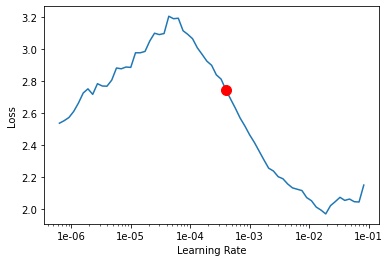

In [4]:
learn.lr_find() 
learn.recorder.plot(suggestion=True)


In [5]:
model_save_name = "EfficientNetWithPreprocessing"
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20,  3.98E-04, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,1.792763,2.518538,0.320505,00:34
1,0.717307,1.169352,0.561691,00:34
2,0.484486,0.535138,0.803595,00:34
3,0.397654,0.379837,0.864486,00:34
4,0.377426,0.337591,0.892775,00:34
5,0.314616,0.311434,0.887078,00:34
6,0.314245,0.370877,0.869069,00:34
7,0.252800,0.326384,0.881507,00:34
8,0.237784,0.302609,0.896882,00:34
9,0.225444,0.318353,0.899975,00:34


Better model found at epoch 0 with valid_loss value: 2.518537759780884.
Better model found at epoch 1 with valid_loss value: 1.1693519353866577.
Better model found at epoch 2 with valid_loss value: 0.5351380109786987.
Better model found at epoch 3 with valid_loss value: 0.3798365592956543.
Better model found at epoch 4 with valid_loss value: 0.3375914394855499.
Better model found at epoch 5 with valid_loss value: 0.3114338517189026.
Better model found at epoch 8 with valid_loss value: 0.3026092052459717.
Better model found at epoch 10 with valid_loss value: 0.2806711196899414.
Better model found at epoch 12 with valid_loss value: 0.25823527574539185.
Epoch 16: early stopping
Model save as: EfficientNetWithPreprocessing


In [9]:

import scipy as sp
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [5]:
learn = Learner(data_2020, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')
learn.load("transformed_testwithlr_stage1")

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,1.0,0.0,4.0,2.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momen

epoch,train_loss,valid_loss,qk,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.58E-03


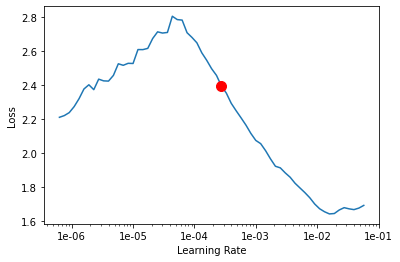

In [6]:
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [7]:
learn.load("EfficientNetB4WithPreprocessingOn2015")
model_save_name = "EfficientNetB4WithPreprocessingOn2015"
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20, 2.75E-04, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.112819,0.286294,0.895934,00:34
1,0.095044,0.299972,0.889203,00:34
2,0.098289,0.290321,0.892125,00:34
3,0.097280,0.279646,0.908932,00:34
4,0.121815,0.267341,0.907791,00:34
5,0.114638,0.261402,0.908609,00:34
6,0.103969,0.334868,0.884173,00:34
7,0.101420,0.266482,0.910169,00:34
8,0.087225,0.248907,0.911537,00:34
9,0.093767,0.290709,0.898400,00:34


Better model found at epoch 0 with valid_loss value: 0.28629356622695923.
Better model found at epoch 3 with valid_loss value: 0.2796460688114166.
Better model found at epoch 4 with valid_loss value: 0.2673412561416626.
Better model found at epoch 5 with valid_loss value: 0.26140186190605164.
Better model found at epoch 8 with valid_loss value: 0.2489074021577835.
Epoch 12: early stopping
Model save as: EfficientNetB4WithPreprocessingOn2015


In [10]:
learn.data.add_test(ImageList.from_df(test_df,
                                      '2019data',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)

0.9283042326259756
[0.564123 1.442981 2.273108 3.290445]


In [11]:
valid_pred = optR.predict(valid_preds[0], [0.5, 1.5, 2.5, 3.5])
cm = confusion_matrix(valid_pred,valid_preds[1])

Confusion matrix, without normalization
[[378   8   2   0   0]
 [  9  34  27   0   2]
 [  0  18 142  21  13]
 [  0   1  12  11  16]
 [  0   0   2   3  34]]


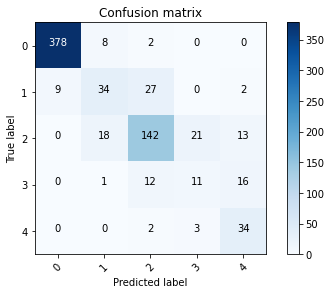

In [12]:
plot_confusion_matrix(cm, classes=range(5), normalize=False)

In [19]:
test_df = pd.read_csv('aptos-data-split/df_2015_cv.csv')[0:1000]

learn.data.add_test(ImageList.from_df(test_df,path ='./',cols='path') )


In [20]:
preds,y = learn.get_preds(DatasetType.Test)
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)
tst_pred = optR.predict(preds, coefficients)
test_df.diagnosis = tst_pred.astype(int)

0.9283042326259756
[0.564123 1.442981 2.273108 3.290445]


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>, <AxesSubplot:title={'center':'Unnamed: 0.1'}>,
        <AxesSubplot:title={'center':'Unnamed: 0.1.1'}>],
       [<AxesSubplot:title={'center':'diagnosis'}>, <AxesSubplot:title={'center':'is_valid1'}>,
        <AxesSubplot:title={'center':'is_valid2'}>],
       [<AxesSubplot:title={'center':'is_valid3'}>, <AxesSubplot:title={'center':'is_valid4'}>,
        <AxesSubplot:title={'center':'is_valid5'}>]], dtype=object)

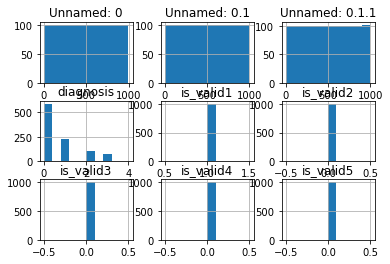

In [21]:
test_df.hist()

In [22]:
test_df.diagnosis

0      0
1      0
2      1
3      2
4      0
      ..
995    1
996    1
997    0
998    0
999    0
Name: diagnosis, Length: 1000, dtype: int64

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
test_df2 = pd.read_csv('aptos-data-split/df_2015_cv.csv')[0:1000]

In [27]:
print(classification_report(test_df.diagnosis, test_df2.diagnosis))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       587
           1       0.21      0.05      0.08       226
           2       0.13      0.17      0.15       110
           3       0.21      0.08      0.12        72
           4       0.08      0.40      0.13         5

    accuracy                           0.50      1000
   macro avg       0.25      0.30      0.23      1000
weighted avg       0.44      0.50      0.45      1000

